In [1]:
library(tidyverse)
library(readxl)
library(rasilabRtemplates)
library(plotrix)
library(ggrepel)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.8     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [2]:
ct_data <- read_excel("../rawdata/2022-08-30_kchen_exp66_r1_qpcr.xls", sheet = "Results", skip=47) %>%
  print()

# A tibble: 58 × 33
    Well Well Positi…¹ Omit  Sampl…² Targe…³ Task  Repor…⁴ Quenc…⁵ CT    Ct Me…⁶
   <dbl> <chr>         <lgl> <chr>   <chr>   <chr> <chr>   <chr>   <chr>   <dbl>
 1     1 A1            FALSE Sample… Target… UNKN… SYBR    None    16.7…    17.3
 2     2 A2            FALSE Sample… Target… UNKN… SYBR    None    17.5…    17.3
 3     3 A3            FALSE Sample… Target… UNKN… SYBR    None    18.3…    17.3
 4     4 A4            FALSE Sample… Target… UNKN… SYBR    None    19.2…    17.3
 5     5 A5            FALSE Sample… Target… UNKN… SYBR    None    19.9…    17.3
 6     6 A6            FALSE Sample… Target… UNKN… SYBR    None    20.7…    17.3
 7     7 A7            FALSE Sample… Target… UNKN… SYBR    None    21.3…    17.3
 8    13 B1            FALSE Sample… Target… UNKN… SYBR    None    7.41…    17.3
 9    14 B2            FALSE Sample… Target… UNKN… SYBR    None    7.30…    17.3
10    15 B3            FALSE Sample… Target… UNKN… SYBR    None    7.56…    17.3
# … with

In [3]:
annotations <- read_csv("../annotations/sample_annotations_r1.csv") %>%
    dplyr::rename(`Well Position` = Well) %>%
    mutate(dil = as.numeric(str_sub(dil, 1,1)) / as.numeric(str_extract(dil, "[^:]+$"))) %>%
    mutate(rt = ifelse(str_detect(sample, '-RT'), 'noRT', 'RT')) %>%
    mutate(sample = ifelse(str_detect(sample, '-RT'), str_extract(sample, "(.+)[^?= ]"), sample)) %>%
    mutate(sample2 = str_extract(sample, ".+(?= )")) %>%
    mutate(sample2 = ifelse(is.na(sample2), sample, sample2))

Rows: 58 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): cDNA input, sample, dil, Well
dbl (1): Tube

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


In [4]:
qpcr_data <- ct_data %>%
    left_join(annotations, by='Well Position') %>%
    select(Tube, "Well Position", CT, sample, `cDNA input`, dil, sample2, rt)

In [5]:
amp_data <- read_excel("../rawdata/2022-08-30_kchen_exp66_r1_qpcr.xls", sheet = "Amplification Data", skip=47) %>%
  print()

# A tibble: 2,880 × 6
    Well `Well Position` Cycle `Target Name`      Rn `Delta Rn`
   <dbl> <chr>           <dbl> <chr>           <dbl>      <dbl>
 1     1 A1                  1 Target 1      -22937.     -101. 
 2     1 A1                  2 Target 1      -22915.     -133. 
 3     1 A1                  3 Target 1      -22686.       42.8
 4     1 A1                  4 Target 1      -22634.       41.6
 5     1 A1                  5 Target 1      -22528.       93.8
 6     1 A1                  6 Target 1      -22653.      -84.1
 7     1 A1                  7 Target 1      -22694.     -179. 
 8     1 A1                  8 Target 1      -22539.      -77.4
 9     1 A1                  9 Target 1      -22397.       10.9
10     1 A1                 10 Target 1      -22203.      152. 
# … with 2,870 more rows
# ℹ Use `print(n = ...)` to see more rows


In [6]:
plot_data <- amp_data %>%
    drop_na() %>%
    left_join(annotations, by="Well Position") %>%
    select(Tube, "Well Position", Cycle, "Delta Rn", sample, `cDNA input`, dil, sample2, rt) %>%
    mutate(order = fct_reorder(as.factor(dil), desc(dil))) %>%
    left_join(select(qpcr_data, c(`Well Position`,CT)), by="Well Position") %>%
    mutate(CT = round(as.numeric(CT), 0))

Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


In [75]:
text_df <- qpcr_data %>%
    mutate(dil = ifelse(sample == "pHPSC1142", "plasmid", dil)) %>%
    mutate(dil = ifelse(sample == "ultrapure", "NTC", dil)) %>%
    mutate(name = fct_reorder(as.factor(dil), desc(dil))) %>%
    mutate(CT = round(as.numeric(CT),0)) %>%
    filter(rt != "noRT") %>%
    # drop_na(CT) %>%
    group_by(dil) %>%
    mutate(avg_ct = round(mean(CT),0))

head(text_df)

Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


Tube,Well Position,CT,sample,cDNA input,dil,sample2,rt,name,avg_ct
<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>,<dbl>
7,B1,7,66gRNA2,66cDNA7,0.5,66gRNA2,RT,0.5,NA
15,B2,7,66gRNA2,66cDNA7,0.25,66gRNA2,RT,0.25,15
23,B3,8,66gRNA2,66cDNA7,0.125,66gRNA2,RT,0.125,13
31,B4,8,66gRNA2,66cDNA7,0.0625,66gRNA2,RT,0.0625,12
39,B5,9,66gRNA2,66cDNA7,0.03125,66gRNA2,RT,0.03125,12
47,B6,10,66gRNA2,66cDNA7,0.015625,66gRNA2,RT,0.015625,13


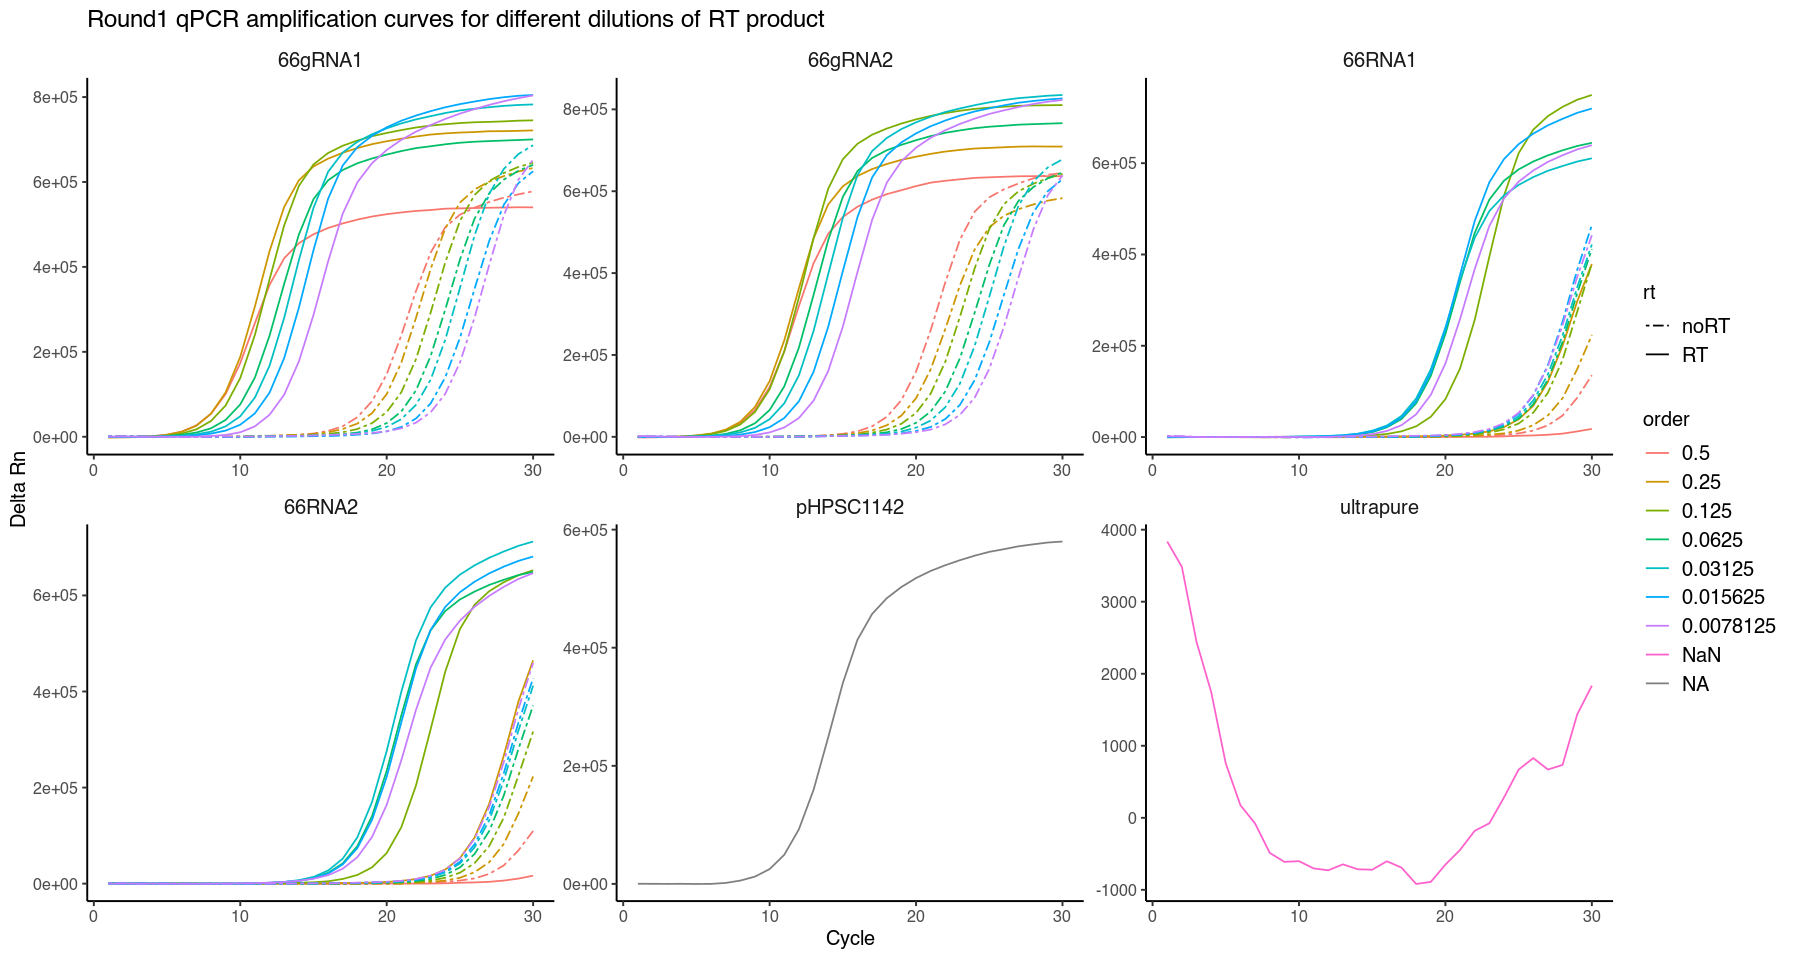

In [7]:
options(repr.plot.width=15, repr.plot.height=8)

plot_data %>%
    ggplot() +
    aes(x=Cycle, y=`Delta Rn`, color=order, linetype=rt) +
    facet_wrap(~sample2, scales='free') +
    geom_line() +
    scale_linetype_manual(values=c("twodash", "solid"))+
    # geom_text(data=text_df, mapping=aes(x=5, y=800000, label=avg_ct), show.legend=F) +
    labs(title="Round1 qPCR amplification curves for different dilutions of RT product")

In [8]:
ggsave("../figures/round1_qpcr_data.jpg", width=15, height=8)

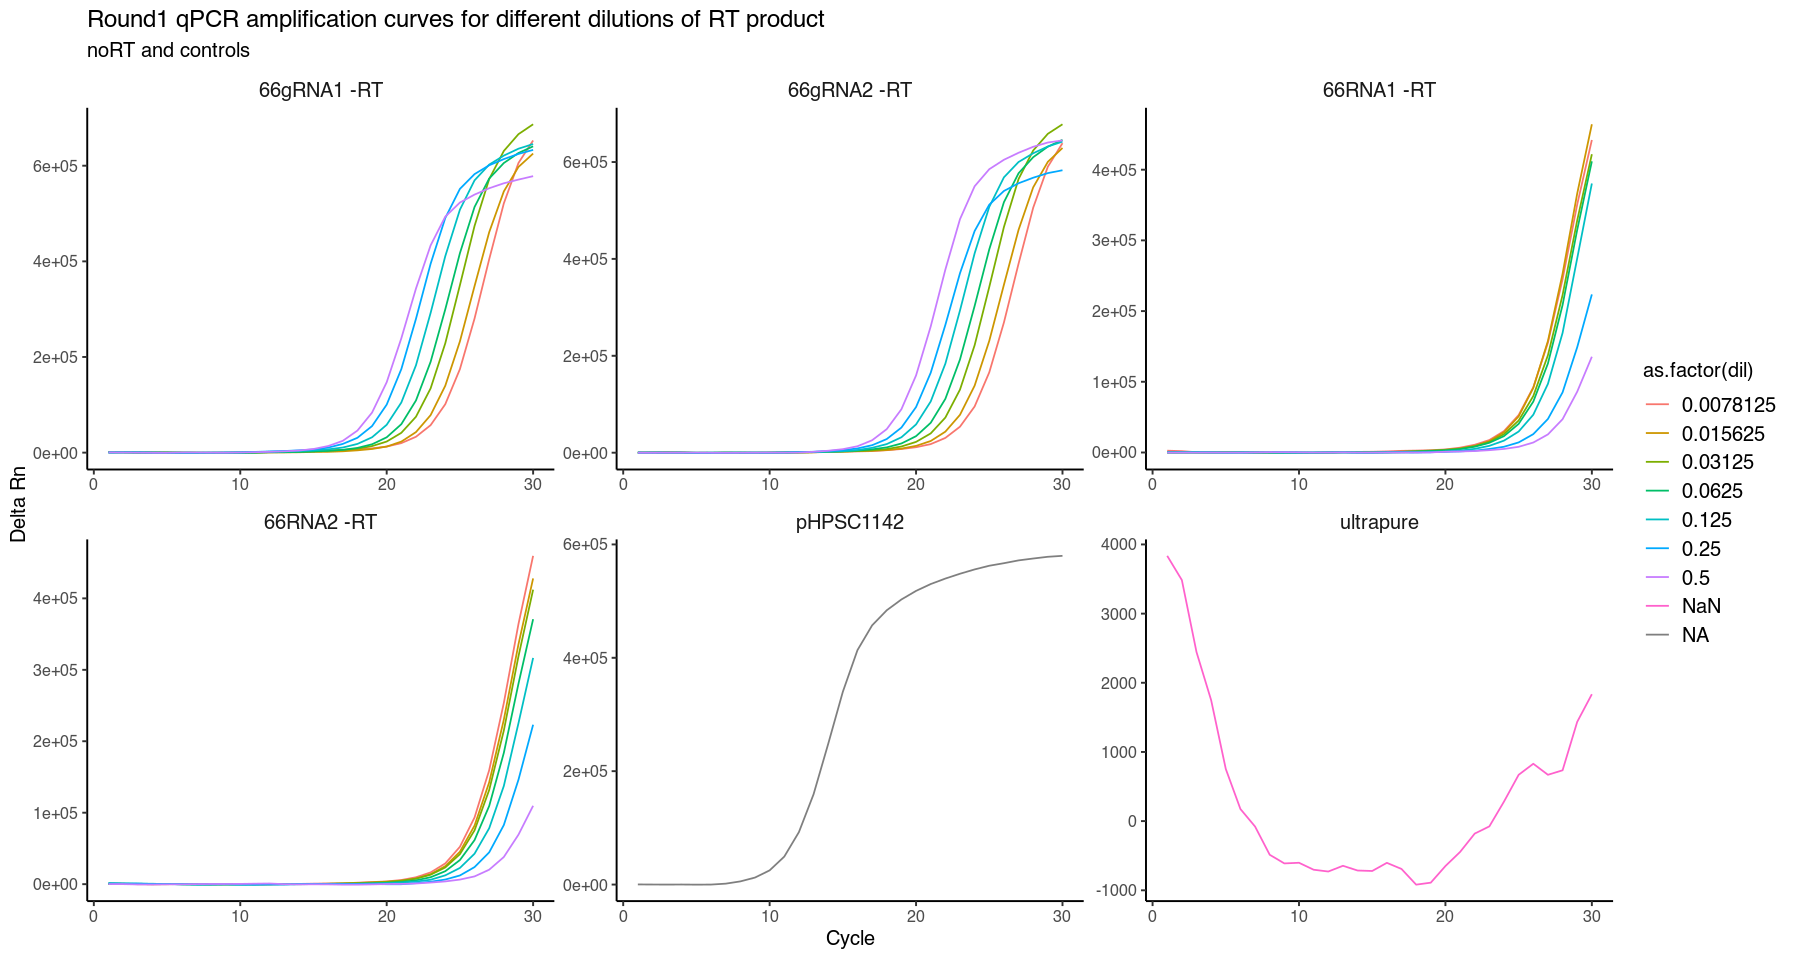

In [102]:
plot_data %>%
    filter(rt == "noRT" | sample == "pHPSC1142" | sample == "ultrapure") %>%
    ggplot() +
    aes(x=Cycle, y=`Delta Rn`, color=as.factor(dil)) +
    facet_wrap(~sample, scales='free') +
    geom_line() +
    # geom_text(data=text_df, mapping=aes(x=10, y=1000000, label=str_c("avg Ct=", round(avg_ct,0))), show.legend=F) +
    labs(title="Round1 qPCR amplification curves for different dilutions of RT product", subtitle="noRT and controls")